# Predicting Job seniority level from job title and description

In [13]:
!pip install torchtext
!pip install spacy
!pip install nltk
!pip install transformers


     |████████████████████████████████| 2.5MB 19.5MB/s 
     |████████████████████████████████| 3.3MB 39.4MB/s 
     |████████████████████████████████| 901kB 42.2MB/s 


## Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from sklearn import metrics

from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def load_data():
    return pd.read_json("./data.json")

In [3]:
data = load_data()

In [30]:
len(data)

216

In [5]:
data["title_len"] = data.title.apply(lambda text: len(text))
data["description_len"] = data.description.apply(lambda text: len(text))

In [6]:
print(np.max(data.title_len), np.mean(data.title_len), np.median(data.title_len))
print(np.max(data.description_len), np.mean(data.description_len), np.median(data.description_len))

95 30.328703703703702 28.0
5927 1764.8194444444443 1788.0


In [37]:
data.description_len.describe()

count     216.000000
mean     1764.819444
std      1069.707932
min         2.000000
25%       973.000000
50%      1788.000000
75%      2493.250000
max      5927.000000
Name: description_len, dtype: float64

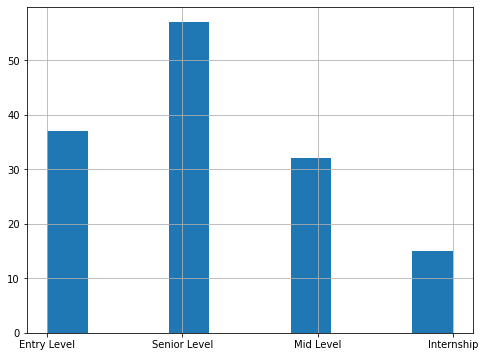

In [9]:
fig = plt.figure(figsize=(8,6))
data.level.hist()
plt.show()
fig.savefig("./target_distribution.png")

In [10]:
def create_testset(data):
    data_test = data.loc[data.level.isnull()]
    data_train = data.loc[~data.level.isnull()]
    return data_train, data_test

In [32]:
df_train, df_test = create_testset(data)

In [44]:
df_test.description


141    OUTFITTERY is Europe’s biggest Personal Shoppi...
142    OUTFITTERY is Europe’s biggest Personal Shoppi...
143    OUTFITTERY is Europe’s biggest Personal Shoppi...
144    OUTFITTERY is Europe’s biggest Personal Shoppi...
145    OUTFITTERY is Europe’s biggest Personal Shoppi...
                             ...                        
211    Work in a one of a kind international environm...
212    Work in a unique international environment and...
213    Photography - New York Habitat Internship\nWho...
214    Are you free every day from 10:30am - 1:30pm a...
215    OUTFITTERY is Europe’s biggest Personal Shoppi...
Name: description, Length: 75, dtype: object

In [ ]:
from sklearn.base import TransformerMixin

class TFIDFTokenize(TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 3), stop_words='english')
        self.label_encoder = LabelEncoder()
        self.column_transform = ColumnTransformer(
                                    [('tfidf_title', self.tfidf, 'title'),
                                     ('tfidf_description', self.tfidf, 'description')])
        
    def fit(self, X, y):
        X = self.column_transform.fit(X)
        y = self.label_encoder.fit(y)
        return X,y
    def fit_transform(self, X, y):
        X = self.column_transform.fit_transform(X)
        y = self.label_encoder.fit_transform(y)
        return X, y
    def transform(self, X, y):
        X = self.column_transform.transform(X)
        y = self.label_encoder.transform(y)
        return X, y


In [ ]:
tf_idf_tokenize = TFIDFTokenize()
X_train, y_train = tf_idf_tokenize.fit_transform(df_train[["title", "description"]], df_train["level"])

In [ ]:
from sklearn.model_selection import StratifiedKFold
def create_folds(X,y):
    X = pd.DataFrame(X.toarray())
    X["targets"] = y
    X["kfold"] = -1
    X = X.sample(frac=1).reset_index(drop=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X=X, y=X.targets.values)):
        X.loc[val_idx, 'kfold'] = fold
    
    X.to_csv('data_folds.csv', index=False)

In [ ]:
def get_train_data(fold):
    FOLD_MAPPPING = {
        0: [1, 2, 3, 4],
        1: [0, 2, 3, 4],
        2: [0, 1, 3, 4],
        3: [0, 1, 2, 4],
        4: [0, 1, 2, 3]
    }

    df = pd.read_csv('data_folds.csv')
    train_df = df[df.kfold.isin(FOLD_MAPPPING.get(fold))].reset_index(drop=True)
    valid_df = df[df.kfold==fold].reset_index(drop=True)
    ytrain = train_df.targets.values
    yvalid = valid_df.targets.values
    train_df = train_df.drop(["targets", "kfold"], axis=1)
    valid_df = valid_df.drop(["targets", "kfold"],axis=1)
    
    
    return (train_df, valid_df, ytrain, yvalid)

In [ ]:
def random_over_sampling(X, y):
    ros = RandomOverSampler(random_state=42)

    X_ros, y_ros = ros.fit_resample(X, y)
    print(X_ros.shape[0] - X.shape[0], 'new random picked points')
    print(sorted(Counter(y_ros).items()))
    
    return X_ros, y_ros

In [ ]:
create_folds(X_train, y_train)

In [ ]:
def train(model):
    for fold in range(5):
        train_df, valid_df, ytrain, yvalid = get_train_data(fold)
        #train_df, ytrain = random_over_sampling(train_df, ytrain)

        model.fit(train_df, ytrain)
        y_pred = model.predict(valid_df)
        print(metrics.accuracy_score(yvalid, y_pred))
        print("Classification Report: \n", metrics.classification_report(yvalid, y_pred))
        print("Confusion matrix: \n", metrics.confusion_matrix(yvalid, y_pred))

In [ ]:
model =  MultinomialNB()
train(model)

0.5517241379310345
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.67      0.67      0.67         3
           2       0.00      0.00      0.00         6
           3       0.57      1.00      0.73        12

    accuracy                           0.55        29
   macro avg       0.48      0.48      0.44        29
weighted avg       0.49      0.55      0.47        29

Confusion matrix: 
 [[ 2  0  2  4]
 [ 0  2  0  1]
 [ 1  1  0  4]
 [ 0  0  0 12]]
0.6071428571428571
Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.60      1.00      0.75         3
           2       1.00      0.17      0.29         6
           3       0.59      0.83      0.69        12

    accuracy                           0.61        28
   macro avg       0.70      0.61      0.56        28
weighted avg    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6428571428571429
Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         6
           3       0.65      1.00      0.79        11

    accuracy                           0.64        28
   macro avg       0.55      0.62      0.58        28
weighted avg       0.52      0.64      0.57        28

Confusion matrix: 
 [[ 4  0  1  3]
 [ 0  3  0  0]
 [ 3  0  0  3]
 [ 0  0  0 11]]


In [ ]:
tf_idf_tokenize.label_encoder.classes_

array(['Entry Level', 'Internship', 'Mid Level', 'Senior Level'],
      dtype=object)

Class `Mid Level` and `Internship` are under represented, we have to tp over sample. Even after the over sampling precession and accuracy for these classes are not better. In general, model is not doing better. I'll try with other models.

In [ ]:
model = XGBClassifier(objective='multi:softprob')
train(model)

0.5172413793103449
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.60      1.00      0.75         3
           2       0.17      0.17      0.17         6
           3       0.67      0.67      0.67        12

    accuracy                           0.52        29
   macro avg       0.48      0.55      0.50        29
weighted avg       0.51      0.52      0.51        29

Confusion matrix: 
 [[3 1 2 2]
 [0 3 0 0]
 [2 1 1 2]
 [1 0 3 8]]
0.6785714285714286
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       1.00      0.33      0.50         3
           2       0.50      0.50      0.50         6
           3       0.85      0.92      0.88        12

    accuracy                           0.68        28
   macro avg       0.71      0.58      0.60        28
weighted avg       0.70      0.6

## Using Embeding

In [ ]:
import torch
import torchtext
from torchtext.data import get_tokenizer
from torchtext._torchtext import RegexTokenizer

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus of 6 billion words
                              dim=50)   # embedding size = 100

.vector_cache/glove.6B.zip:  19%|█▊        | 161M/862M [00:30<02:12, 5.29MB/s]  


KeyboardInterrupt: ignored

In [ ]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._E = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus of 6 billion words
                              dim=50)   # embedding size = 100
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w].numpy() for w in doc]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [ ]:
from spacy.lang.en import English
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import re

class TextPreprocess:
    def __init__(self):
        pass
    
    def _tokenize(self, text):

        nlp = English()
        tokenizer = nlp.tokenizer
        tokens = tokenizer(text)
        tokens_list =   []
        for token in tokens:
            if (not token.is_stop) and \
            (not token.is_punct) and \
            (not token.is_digit) and \
            (len(token) > 3):
                tokens_list.append(token.lower_)
        return tokens_list

    def _punctuation(self, tokens):
        if isinstance((tokens), (str)):
            tokens = re.sub('<[^>]*>', '', tokens)
            tokens = re.sub('[\W]+', '', tokens.lower())
            return tokens
        if isinstance((tokens), (list)):
            return_list = []
            for i in range(len(tokens)):
                temp_text = re.sub('<[^>]*>', '', tokens[i])
                temp_text = re.sub('[\W]+', '', temp_text.lower())
                return_list.append(temp_text)
            return(return_list)
        else:
            pass
    
    def _pipelinize(self, function, active=True):
        def list_comprehend_a_function(list_or_series, active=True):
            if active:
                return [function(i) for i in list_or_series]
            else: # if it's not active, just pass it right back
                return list_or_series
        return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})
    
    def __call__(self, text):
        estimators = [('tokenizer', self._pipelinize(self._tokenize)),
                      ('puntuation', self._pipelinize(self._punctuation))]
        pipe = Pipeline(estimators)
        return pipe.transform([text])[0]
        

In [ ]:
def tokenize_and_transform(X):
    text_process = TextPreprocess()

    X = X[['title', 'description']].values
    title = X[:, 0]
    #print(title)
    description = X[:, 1]
    #print(X)
    title = [text_process(doc) for doc in title]
    description = [text_process(doc) for doc in description]
    met = MeanEmbeddingTransformer()
    X_transform = np.concatenate([met.fit_transform(title), met.fit_transform(description)], axis=1)
    return X_transform

In [ ]:
X_transform = tokenize_and_transform(df_train)

In [ ]:
def train_with_embedings(model):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_train, y=df_train.level.values)):
        X_train = tokenize_and_transform(df_train.loc[train_idx, ['title', 'description']])
        X_valid = tokenize_and_transform(df_train.loc[val_idx, ['title', 'description']])
        y_train = df_train.loc[train_idx, 'level']
        y_valid = df_train.loc[val_idx, 'level']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        print(metrics.accuracy_score(y_valid, y_pred))
        print("Classification Report: \n", metrics.classification_report(y_valid, y_pred))
        print("Confusion matrix: \n", metrics.confusion_matrix(y_valid, y_pred))

In [ ]:
model = XGBClassifier(objective='multi:softprob')
train_with_embedings(model)

## Using Pretraid BERT model and pretrain for our task

In [14]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
t = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [15]:
class JobsDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
        self.max_len = max_len
        self._label_encode()

    
    def _label_encode(self):
        self.label_encoder = LabelEncoder()
        self.data["level"] = self.label_encoder.fit_transform(self.data.level)
    
    def __getitem__(self, index):
        title = str(self.data.title[index])
        title = " ".join(title.split())
        description = str(self.data.description[index])
        description = " ".join(description.split())
        inputs = self.tokenizer.encode_plus(
            text=title,
            text_pair=description,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.level[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [16]:
# Creating the dataset and dataloader for the neural network

training_set = JobsDataset(df_train, 512)
validation_set = JobsDataset(df_train, 512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
train_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 4
                }

test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 4
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(validation_set, **test_params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [20]:
model = DistillBERTClass()
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
LEARNING_RATE = 1e-03
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [22]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [28]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    y_preds = []
    y_true = []
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)
        y_preds.extend(list(big_idx.cpu().detach().numpy()))
        y_true.extend(list(targets.cpu().detach().numpy()))
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    #print(metrics.accuracy_score(y_true, y_preds))
    print(f"Precision: {metrics.precision_score(y_true, y_preds, average='weighted')}")
    print(f"Accuracy: {metrics.accuracy_score(y_true, y_preds)}")
    print(f"Recall: {metrics.recall_score(y_true, y_preds, average='weighted')}")
    print(f"F1 score: {metrics.f1_score(y_true, y_preds, average='weighted')}")
    print("Classification Report: \n", metrics.classification_report(y_true, y_preds))
    print("Confusion matrix: \n", metrics.confusion_matrix(y_true, y_preds))

    return 

In [29]:
for epoch in range(50):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training Loss per 5000 steps: 1.4919551610946655
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 0: 29.78723404255319
Training Loss Epoch: 1.4064602189593844
Training Accuracy Epoch: 29.78723404255319
Precision: 0.20484633569739952
Accuracy: 0.2978723404255319
Recall: 0.2978723404255319
F1 score: 0.2329727148689448
Classification Report: 
               precision    recall  f1-score   support

           0       0.15      0.08      0.11        37
           1       0.00      0.00      0.00        15
           2       0.05      0.03      0.04        32
           3       0.38      0.67      0.49        57

    accuracy                           0.30       141
   macro avg       0.14      0.19      0.16       141
weighted avg       0.20      0.30      0.23       141

Confusion matrix: 
 [[ 3  0  9 25]
 [ 1  0  4 10]
 [ 5  0  1 26]
 [11  0  8 38]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length`

Training Loss per 5000 steps: 1.5007097721099854
Training Accuracy per 5000 steps: 18.75
The Total Accuracy for Epoch 1: 36.170212765957444
Training Loss Epoch: 1.3562612003750272
Training Accuracy Epoch: 36.170212765957444
Precision: 0.32964549748100963
Accuracy: 0.3617021276595745
Recall: 0.3617021276595745
F1 score: 0.3356363031202482
Classification Report: 
               precision    recall  f1-score   support

           0       0.35      0.22      0.27        37
           1       0.00      0.00      0.00        15
           2       0.28      0.47      0.35        32
           3       0.43      0.49      0.46        57

    accuracy                           0.36       141
   macro avg       0.27      0.29      0.27       141
weighted avg       0.33      0.36      0.34       141

Confusion matrix: 
 [[ 8  0 15 14]
 [ 1  0  3 11]
 [ 5  0 15 12]
 [ 9  0 20 28]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.4252909421920776
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 2: 40.42553191489362
Training Loss Epoch: 1.3248252868652344
Training Accuracy Epoch: 40.42553191489362
Precision: 0.25151608592866687
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.24530823786142938
Classification Report: 
               precision    recall  f1-score   support

           0       0.33      0.03      0.05        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.41      0.98      0.57        57

    accuracy                           0.40       141
   macro avg       0.18      0.25      0.16       141
weighted avg       0.25      0.40      0.25       141

Confusion matrix: 
 [[ 1  0  0 36]
 [ 0  0  0 15]
 [ 1  0  0 31]
 [ 1  0  0 56]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2217386960983276
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 3: 30.49645390070922
Training Loss Epoch: 1.35323166847229
Training Accuracy Epoch: 30.49645390070922
Precision: 0.18662196179195517
Accuracy: 0.3049645390070922
Recall: 0.3049645390070922
F1 score: 0.2310553161616991
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.14      0.19      0.16        32
           3       0.38      0.65      0.48        57

    accuracy                           0.30       141
   macro avg       0.13      0.21      0.16       141
weighted avg       0.19      0.30      0.23       141

Confusion matrix: 
 [[ 0  0 11 26]
 [ 0  0  6  9]
 [ 1  0  6 25]
 [ 1  0 19 37]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.4324698448181152
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 4: 26.24113475177305
Training Loss Epoch: 1.3456386857562594
Training Accuracy Epoch: 26.24113475177305
Precision: 0.18247473566622505
Accuracy: 0.2624113475177305
Recall: 0.2624113475177305
F1 score: 0.21016034535923528
Classification Report: 
               precision    recall  f1-score   support

           0       0.23      0.49      0.31        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.30      0.33      0.32        57

    accuracy                           0.26       141
   macro avg       0.13      0.20      0.16       141
weighted avg       0.18      0.26      0.21       141

Confusion matrix: 
 [[18  0  0 19]
 [10  0  0  5]
 [12  0  0 20]
 [38  0  0 19]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3113377094268799
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 5: 40.42553191489362
Training Loss Epoch: 1.3563573625352647
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2477084398269653
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 6: 41.843971631205676
Training Loss Epoch: 1.3033739063474867
Training Accuracy Epoch: 41.843971631205676
Precision: 0.27856121831876407
Accuracy: 0.41843971631205673
Recall: 0.41843971631205673
F1 score: 0.2882822312178132
Classification Report: 
               precision    recall  f1-score   support

           0       0.42      0.14      0.20        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.42      0.95      0.58        57

    accuracy                           0.42       141
   macro avg       0.21      0.27      0.20       141
weighted avg       0.28      0.42      0.29       141

Confusion matrix: 
 [[ 5  0  0 32]
 [ 0  0  0 15]
 [ 4  0  0 28]
 [ 3  0  0 54]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2499513626098633
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 7: 40.42553191489362
Training Loss Epoch: 1.3312690787845187
Training Accuracy Epoch: 40.42553191489362
Precision: 0.2934979551690221
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.25481804061295715
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.05      0.10        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      0.96      0.57        57

    accuracy                           0.40       141
   macro avg       0.23      0.25      0.17       141
weighted avg       0.29      0.40      0.25       141

Confusion matrix: 
 [[ 2  0  0 35]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 2  0  0 55]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.352394700050354
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 8: 39.00709219858156
Training Loss Epoch: 1.3170448674096003
Training Accuracy Epoch: 39.00709219858156
Precision: 0.32312814682475227
Accuracy: 0.3900709219858156
Recall: 0.3900709219858156
F1 score: 0.2527357004948676
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.03      0.05        37
           1       0.00      0.00      0.00        15
           2       0.12      0.03      0.05        32
           3       0.40      0.93      0.56        57

    accuracy                           0.39       141
   macro avg       0.26      0.25      0.17       141
weighted avg       0.32      0.39      0.25       141

Confusion matrix: 
 [[ 1  0  3 33]
 [ 0  0  1 14]
 [ 0  0  1 31]
 [ 1  0  3 53]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.227081537246704
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 9: 39.00709219858156
Training Loss Epoch: 1.3029898007710774
Training Accuracy Epoch: 39.00709219858156
Precision: 0.23486669993497555
Accuracy: 0.3900709219858156
Recall: 0.3900709219858156
F1 score: 0.24820669657474825
Classification Report: 
               precision    recall  f1-score   support

           0       0.29      0.05      0.09        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      0.93      0.55        57

    accuracy                           0.39       141
   macro avg       0.17      0.25      0.16       141
weighted avg       0.23      0.39      0.25       141

Confusion matrix: 
 [[ 2  0  0 35]
 [ 0  0  0 15]
 [ 1  0  0 31]
 [ 4  0  0 53]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3402705192565918
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 10: 39.716312056737586
Training Loss Epoch: 1.3094133933385212
Training Accuracy Epoch: 39.716312056737586
Precision: 0.16286545231899585
Accuracy: 0.3971631205673759
Recall: 0.3971631205673759
F1 score: 0.23100303951367784
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      0.98      0.57        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 1  0  0 14]
 [ 0  0  0 32]
 [ 1  0  0 56]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3227530717849731
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 11: 40.42553191489362
Training Loss Epoch: 1.3117891152699788
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3981075286865234
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 12: 40.42553191489362
Training Loss Epoch: 1.3040163649453058
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.1731297969818115
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 13: 39.716312056737586
Training Loss Epoch: 1.3062285052405462
Training Accuracy Epoch: 39.716312056737586
Precision: 0.16286545231899585
Accuracy: 0.3971631205673759
Recall: 0.3971631205673759
F1 score: 0.23100303951367784
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      0.98      0.57        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 1  0  0 14]
 [ 0  0  0 32]
 [ 1  0  0 56]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2050377130508423
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 14: 40.42553191489362
Training Loss Epoch: 1.2946655485365126
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.299790382385254
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 15: 40.42553191489362
Training Loss Epoch: 1.3231763177447848
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.1767321825027466
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 16: 40.42553191489362
Training Loss Epoch: 1.307920840051439
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2045552730560303
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 17: 40.42553191489362
Training Loss Epoch: 1.3080027103424072
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2824816703796387
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 18: 41.13475177304964
Training Loss Epoch: 1.3074522150887384
Training Accuracy Epoch: 41.13475177304964
Precision: 0.4270010131712259
Accuracy: 0.41134751773049644
Recall: 0.41134751773049644
F1 score: 0.24774567372096945
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.03      0.05        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.41      1.00      0.58        57

    accuracy                           0.41       141
   macro avg       0.35      0.26      0.16       141
weighted avg       0.43      0.41      0.25       141

Confusion matrix: 
 [[ 1  0  0 36]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.288136601448059
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 19: 40.42553191489362
Training Loss Epoch: 1.3005239168802898
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3444360494613647
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 20: 40.42553191489362
Training Loss Epoch: 1.3011667595969305
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.1753162145614624
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 21: 40.42553191489362
Training Loss Epoch: 1.3185833030276828
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.4236981868743896
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 22: 40.42553191489362
Training Loss Epoch: 1.320298194885254
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2811315059661865
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 23: 40.42553191489362
Training Loss Epoch: 1.300109174516466
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.385535717010498
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 24: 40.42553191489362
Training Loss Epoch: 1.313484960132175
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.439029574394226
Training Accuracy per 5000 steps: 18.75
The Total Accuracy for Epoch 25: 40.42553191489362
Training Loss Epoch: 1.3070845471488104
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2242047786712646
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 26: 40.42553191489362
Training Loss Epoch: 1.2938222885131836
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2383849620819092
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 27: 40.42553191489362
Training Loss Epoch: 1.296237177318997
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2722207307815552
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 28: 40.42553191489362
Training Loss Epoch: 1.3008288277520075
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.5894516706466675
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 29: 40.42553191489362
Training Loss Epoch: 1.3125920560624864
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3453547954559326
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 30: 40.42553191489362
Training Loss Epoch: 1.3068204058541193
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.4838203191757202
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 31: 40.42553191489362
Training Loss Epoch: 1.3064734670850966
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2590763568878174
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 32: 40.42553191489362
Training Loss Epoch: 1.2975840436087713
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2577077150344849
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 33: 41.13475177304964
Training Loss Epoch: 1.3113491137822468
Training Accuracy Epoch: 41.13475177304964
Precision: 0.4270010131712259
Accuracy: 0.41134751773049644
Recall: 0.41134751773049644
F1 score: 0.24774567372096945
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.03      0.05        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.41      1.00      0.58        57

    accuracy                           0.41       141
   macro avg       0.35      0.26      0.16       141
weighted avg       0.43      0.41      0.25       141

Confusion matrix: 
 [[ 1  0  0 36]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2890634536743164
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 34: 40.42553191489362
Training Loss Epoch: 1.292551702923245
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.345952033996582
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 35: 40.42553191489362
Training Loss Epoch: 1.3047138452529907
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.1162396669387817
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 36: 40.42553191489362
Training Loss Epoch: 1.2983293930689495
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.478130578994751
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 37: 40.42553191489362
Training Loss Epoch: 1.315945757759942
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.5413058996200562
Training Accuracy per 5000 steps: 18.75
The Total Accuracy for Epoch 38: 40.42553191489362
Training Loss Epoch: 1.2996850146187677
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.3093764781951904
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 39: 40.42553191489362
Training Loss Epoch: 1.2931603988011677
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.1398588418960571
Training Accuracy per 5000 steps: 56.25
The Total Accuracy for Epoch 40: 40.42553191489362
Training Loss Epoch: 1.3250541422102187
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2275512218475342
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 41: 40.42553191489362
Training Loss Epoch: 1.307007246547275
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.419242024421692
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 42: 40.42553191489362
Training Loss Epoch: 1.3090740177366469
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2770406007766724
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 43: 40.42553191489362
Training Loss Epoch: 1.331023375193278
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2767760753631592
Training Accuracy per 5000 steps: 31.25
The Total Accuracy for Epoch 44: 40.42553191489362
Training Loss Epoch: 1.311739484469096
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2974516153335571
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 45: 40.42553191489362
Training Loss Epoch: 1.2864548630184598
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2179954051971436
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 46: 40.42553191489362
Training Loss Epoch: 1.3184334172142878
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2723469734191895
Training Accuracy per 5000 steps: 68.75
The Total Accuracy for Epoch 47: 40.42553191489362
Training Loss Epoch: 1.3072560363345676
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2388206720352173
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 48: 40.42553191489362
Training Loss Epoch: 1.2995729049046834
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Loss per 5000 steps: 1.2153315544128418
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 49: 40.42553191489362
Training Loss Epoch: 1.3137777116563585
Training Accuracy Epoch: 40.42553191489362
Precision: 0.16342236306020824
Accuracy: 0.40425531914893614
Recall: 0.40425531914893614
F1 score: 0.23275306254029654
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        32
           3       0.40      1.00      0.58        57

    accuracy                           0.40       141
   macro avg       0.10      0.25      0.14       141
weighted avg       0.16      0.40      0.23       141

Confusion matrix: 
 [[ 0  0  0 37]
 [ 0  0  0 15]
 [ 0  0  0 32]
 [ 0  0  0 57]]


In [47]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(df_train.level)

array([0, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3,
       3, 0, 3, 3, 0, 2, 0, 3, 3, 3, 1, 3, 0, 3, 2, 2, 3, 0, 3, 3, 3, 3,
       2, 2, 0, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 0, 2, 3, 1, 1, 2,
       1, 1, 1, 0, 1, 1, 1, 2, 2, 3, 2, 2, 2, 0, 0, 0, 0, 3, 2, 3, 0, 0,
       3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 3, 2, 1, 3, 2, 3,
       2, 0, 0, 3, 2, 1, 3, 0, 1, 3, 3, 0, 2, 3, 3, 1, 0, 0, 3, 3, 3, 3,
       3, 2, 1, 1, 0, 0, 3, 0, 3])

In [50]:
label_encoder.classes_


array(['Entry Level', 'Internship', 'Mid Level', 'Senior Level'],
      dtype=object)

In [51]:
label_encoder.inverse_transform([0, 1, 2, 3])

array(['Entry Level', 'Internship', 'Mid Level', 'Senior Level'],
      dtype=object)